HHL算法解的x为负值，量子测量该怎么表示？
在量子计算中，我们通常使用复数来表示量子态。因此，负数可以直接在量子态中表示。然而，当我们进行测量时，我们只能得到量子态的概率分布，而不能直接得到负数。在HHL算法中，我们通常通过测量得到的结果来估计解向量的各个元素。如果解向量的元素为负数，我们可以通过调整我们的测量策略来解决这个问题。例如，我们可以将解向量的所有元素加上一个大的正数，使得所有的元素都变为正数。然后，我们可以使用HHL算法来求解调整后的线性方程组。最后，我们可以将得到的解向量的所有元素减去之前加上的那个大的正数，从而得到原始线性方程组的解。这种方法可以处理解向量中包含负数的情况。然而，这种方法可能会增加问题的复杂性，因为我们需要处理更大的数。在实际应用中，我们需要根据具体的问题和量子硬件的性能来选择合适的策略。

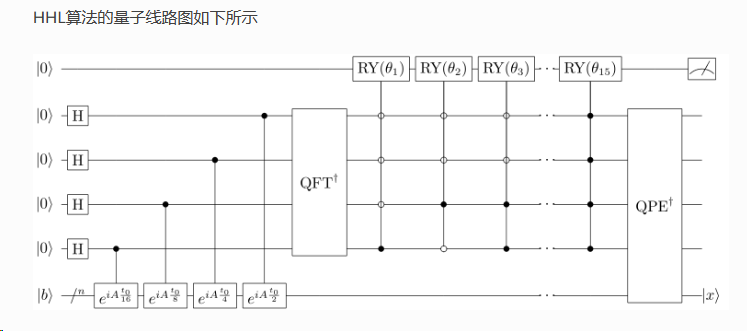

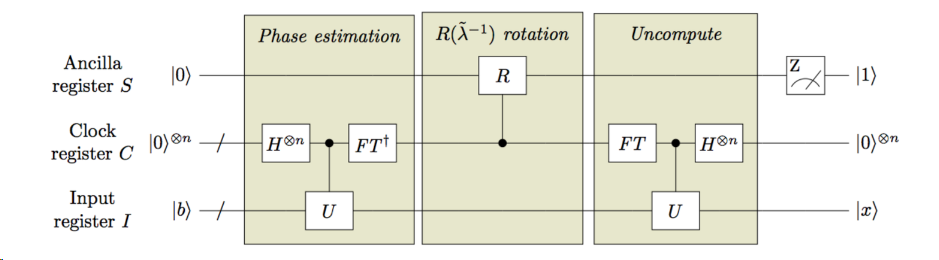

In [1]:
from typing import Any, List, Optional, Union

import deepquantum as dq
import numpy as np
import torch
from deepquantum.qmath import is_unitary


class QuantumPhaseEstimation(dq.Ansatz):
    def __init__(
        self,
        nqubit: int,
        ncount: int,
        unitary: Any,
        minmax: Optional[List[int]] = None,
        den_mat: bool = False,
        mps: bool = False,
        chi: Optional[int] = None,
        show_barrier: bool = False
    ) -> None:
        if not isinstance(unitary, torch.Tensor):
            unitary = torch.tensor(unitary, dtype=torch.cfloat)
        assert is_unitary(unitary)
        nreg_i = int(np.log2(len(unitary)))
        if minmax is None:
            minmax = [0, ncount + nreg_i - 1]
        assert minmax[1] - minmax[0] == ncount + nreg_i - 1
        self.unitary = unitary
        super().__init__(nqubit=nqubit, wires=None, minmax=minmax, ancilla=None, controls=None,
                         init_state='zeros', name='QuantumPhaseEstimation', den_mat=den_mat,
                         mps=mps, chi=chi)
        wires_c = list(range(minmax[0], minmax[0] + ncount))
        wires_i = list(range(minmax[0] + ncount, minmax[1] + 1))
        self.hlayer(wires_c)
        if show_barrier:
            self.barrier()
        for i, wire in enumerate(wires_c):
            u = torch.linalg.matrix_power(self.unitary, 2 ** (ncount - 1 - i))
            self.any(unitary=u, wires=wires_i, controls=wire)
        if show_barrier:
            self.barrier()
        iqft = dq.QuantumFourierTransform(nqubit=nqubit, minmax=[wires_c[0], wires_c[-1]], den_mat=self.den_mat,
                                          mps=self.mps, chi=self.chi, show_barrier=show_barrier).inverse()
        self.add(iqft)


class HHL(dq.Ansatz):
    def __init__(
        self,
        ncount: int,
        mat: Any,
        t0: float = 1,
        den_mat: bool = False,
        mps: bool = False,
        chi: Optional[int] = None,
        show_barrier: bool = False
    ) -> None:
        if not isinstance(mat, torch.Tensor):
            mat = torch.tensor(mat)
        t0 *= 2 * torch.pi
        unitary = torch.linalg.matrix_exp(1j * mat * t0 / 2 ** ncount)
        assert is_unitary(unitary)
        nreg_i = int(np.log2(len(unitary)))
        nqubit = 1 + ncount + nreg_i
        self.unitary = unitary
        super().__init__(nqubit=nqubit, wires=None, minmax=None, ancilla=None, controls=None,
                         init_state='zeros', name='HHL', den_mat=den_mat, mps=mps, chi=chi)
        qpe = QuantumPhaseEstimation(nqubit=nqubit, ncount=ncount, unitary=unitary, minmax=[1, nqubit-1],
                                     den_mat=self.den_mat, mps=self.mps, chi=self.chi, show_barrier=show_barrier)
        self.add(qpe)
        if show_barrier:
            self.barrier()

        # 旋转线路需要根据矩阵的特征值确定
        for i in range(2 ** ncount):
            for j in range(ncount):
                if format(i, '0' + str(ncount) + 'b')[ncount-j-1] == '0':
                    self.x(1 + j)
            theta = 2 * torch.pi * i / 2 ** ncount
            self.ry(0, inputs=theta, controls=list(range(1, ncount+1)))
            for j in range(ncount):
                if format(i, '0' + str(ncount) + 'b')[ncount-j-1] == '0':
                    self.x(1 + j)
            if show_barrier:
                self.barrier()

        iqpe = qpe.inverse()
        self.add(iqpe)
        if show_barrier:
            self.barrier()

In [2]:
# 该网络模型可用于特征值为整数的厄米矩阵A，如果特征值不是整数，需要调节合适的t0值，用于U演化。
# 例子1
ncount = 4      # 定义测量比特数，测量比特的数量影响测量相位的精度。
nancilla = 2    # 定义辅助比特数，辅助比特的数量对应测量的酉矩阵大小。
nqubit = 1 + ncount + nancilla # 总比特数
mat = 1/4 * torch.tensor([[15, 9, 5, -3],
                          [9, 15, 3, -5],
                          [5, 3, 15, -9],
                          [-3, -5, -9, 15]]) # A矩阵，特征值为8,4,2,1
b = [0,0,0,1]   # b向量
t0 = 1          # 设置t0时，要保证(2^ncount)*(A的所有特征值)*t0 为整数。


# # 例子2
# ncount = 4      # 定义测量比特数，测量比特的数量影响测量相位的精度。
# nancilla = 1    # 定义辅助比特数，辅助比特的数量对应测量的酉矩阵大小。
# nqubit = 1 + ncount + nancilla # 总比特数
# mat = torch.tensor([[4.,1], [1,4]]) # A矩阵，特征值为5,3
# b = [1, 1]      # b向量
# t0 = 1          # 设置t0时，要保证(2^ncount)*(A的所有特征值)*t0 为整数。

hhl = HHL(ncount=ncount, mat=mat, t0=t0, show_barrier=True)
state = dq.QubitState(nqubit, state=b).state
res = hhl(state=state)
counts = hhl.measure(shots=100000)
print(counts)

{'0000011': 42824, '1000011': 32537, '1000010': 8034, '0000010': 8974, '0000001': 3537, '0000000': 2615, '1000001': 1411, '1000000': 68}


In [3]:
# 计算投点的保真度结果
p = np.zeros([len(b), 1])
for i in range(len(b)):
    try:
        p[i] = counts['1' + '0' * ncount + format(i, '0' + str(nancilla) + 'b')]
    except:
        p[i] = 0
ss = sum(p)
p = p / ss
print('量子投点概率计算：' + str(p))

# 计算准确的解
x = np.linalg.inv(mat) @ np.mat(b).T
x = np.array(x)
# 将准确的解
x = x ** 2 / sum(x ** 2)
print('准确值：' + str(x))

fidelity = 0
for i in range(2 ** nancilla):
    fidelity = np.sqrt(x[i] * p[i]) + fidelity
fidelity = fidelity ** 2
print('保真度：' + str(fidelity))

量子投点概率计算：[[0.00161712]
 [0.03355529]
 [0.19105826]
 [0.77376932]]
准确值：[[0.02647059]
 [0.07352941]
 [0.23823529]
 [0.66176471]]
保真度：[0.97050129]


In [4]:
# 计算结果与正确答案的余弦相似度
p = res[len(res) // 2 : len(res) // 2 + len(b)]
# p = hhl.tensor_rep(res)[0][tuple([1] + [0] * ncount)]
p = abs(p) ** 2
ss = sum(p)
p = p / ss
print('量子概率计算：' + str(p))

# 计算准确的解
x = np.linalg.inv(mat) @ np.mat(b).T
x = np.array(x)
# 将准确的解
x = x ** 2 / sum(x ** 2)
# x = x ** 2
# x = x / sum(x ** 2) ** 0.5
x = torch.tensor(x)
print('准确值：' + str(x))

print('余弦相似度：' + str(sum(x * p) / (sum(abs(x) ** 2) ** 0.5 * sum(abs(p) ** 2) ** 0.5)))

量子概率计算：tensor([[0.0016],
        [0.0343],
        [0.1893],
        [0.7748]])
准确值：tensor([[0.0265],
        [0.0735],
        [0.2382],
        [0.6618]], dtype=torch.float64)
余弦相似度：tensor([0.9919], dtype=torch.float64)


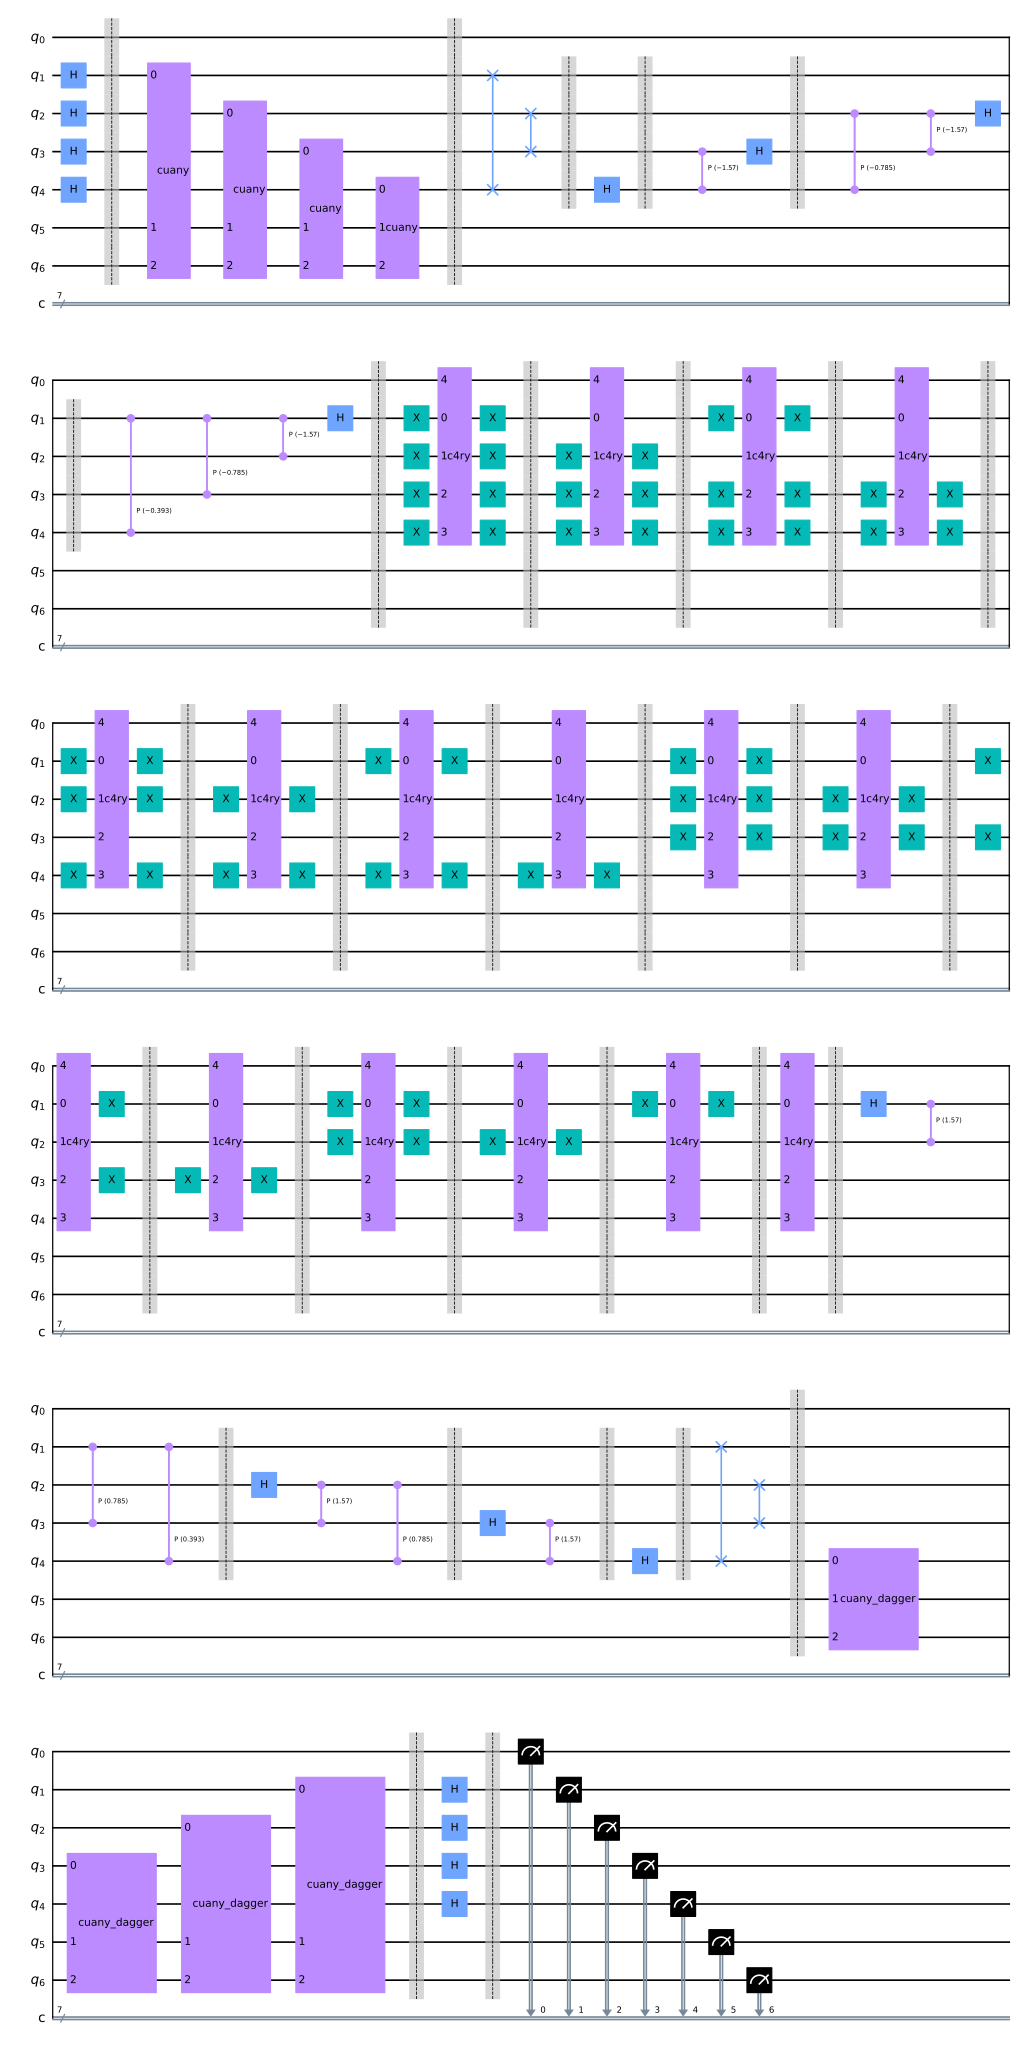

In [5]:
hhl.draw() # 画出线路